<center><h1 style='background:DeepSkyBlue;color:white'>Disaster Tweets – Deep NLP Analysis & [<img src='https://i.imgur.com/DFetacC.png' width='20px' height='30px'/>] Distributed Training DistilBert-N-grams-sst-en</h1></center>

<center>
    <img src='https://i.imgur.com/UYkdJD7.png'>
</center>

Copyright [2022] [AI Engineer: [Ahmed](https://www.kaggle.com/dsxavier/)]

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# 📖<font size='5' color='DarkViolet'>Overview</font>

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

# 📝<font size='5' color='DarkViolet'>Acknowledgments</font>

This dataset was created by the company figure-eight and originally shared on their ‘[Data For Everyone’ website here](https://www.figure-eight.com/data-for-everyone/).

Tweet source: https://twitter.com/AnyOtherAnnaK/status/629195955506708480

# 📝<font size='5' color='DarkViolet'>Proof of Work</font>

I decided to use the **Transfer Learning** in this project and **Fine-tune** it since I believe in not to re-invent the wheels. We're going to use one of my favourite libraries; it's **Hugging Face**. It is the library – you need to use to inject your model with a pre-trained model that has trained on billions of examples.

# 📚<font size='5' color='DarkViolet'>Dictionary</font>

<table>
<thead>
  <tr>
    <th>Variables</th>
    <th>Definition</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>id</td>
    <td>a unique identifier for each tweet</td>
  </tr>
  <tr>
    <td>text</td>
    <td>the text of the tweet</td>
  </tr>
  <tr>
    <td>location</td>
    <td>the location the tweet was sent from (may be blank)</td>
  </tr>
  <tr>
    <td>keyword</td>
    <td>a particular keyword from the tweet (may be blank)</td>
  </tr>
  <tr>
    <td>target</td>
    <td>in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)</td>
  </tr>
</tbody>
</table>

# 🔖<font size='5' color='DarkViolet'>Dependencies</font>

# <font size='4' color='Violet'><b>(A) Install Dependencies</b></font>

In [ ]:
%config Completer.use_jedi = False

In [ ]:
# If you're running this notebook on kaggle, add this dataset to your notebook
# using this link: https://www.kaggle.com/atamazian/pyspellchecker
# It is really helpful for offline installation. Ref: @atamazian
!pip install -q ../input/pyspellchecker/pyspellchecker-0.6.3-py3-none-any.whl
import sys  
!{sys.executable} -m pip install -q contractions
# !pip install -U -q pyspellchecker
# !pip install -U -q pattern # Uncomment it for comparing the text correction

In [ ]:
# !pip install -U -q tensorflow # Uncomment if you don't have the package!

In [ ]:
# !pip install --user -q transformers #If you don't have it, just uncomment the line and setup the library

In [ ]:
# !pip install -U -q nltk #If you don't have it, just uncomment the line and setup the library

In [ ]:
!pip install -q wandb

# <font size='4' color='Violet'><b>(B) Import Libraries</b></font>

In [ ]:
try:
    from kaggle_secrets import UserSecretsClient
    import wandb
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("wandb_api")
    wandb.login(key=secret_value_0)
    anony=None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    
CONFIG = dict(competition = 'TwitterNLP',_wandb_kernel = 'ai-ahmed')

In [ ]:
import os
import datetime
import warnings
warnings.filterwarnings('ignore')
import threading
import time, timeit
from typing import Text, Dict, List, Union, Tuple, Optional, Set
import re
from ast import literal_eval
from collections import defaultdict, Counter

import emoji

import pandas as pd
pd.set_option('display.max_colwidth', 200)
warnings.filterwarnings('ignore')

from pandarallel import pandarallel # Panadas Asynchronous processing
pandarallel.initialize()

import numpy as np

import seaborn as sns
import matplotlib.pylab as plt

import contractions
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from spellchecker import SpellChecker
from pattern.en import suggest

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


from transformers import (AutoTokenizer, TFAutoModelForSequenceClassification,
                          DistilBertTokenizerFast, TFDistilBertModel)

import tensorflow as tf
import tensorflow_addons as tfa
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import (Dropout, Dense, BatchNormalization,
                                     Activation, concatenate)
from tensorflow.keras.models import Model

from wandb.keras import WandbCallback
from IPython.display import clear_output
%matplotlib inline

**Main Params for Matplotlib**

In [ ]:
plt.rcParams['figure.figsize'] = [18, 15]
plt.style.use('fivethirtyeight')

**Main Params for Seaborn**

In [ ]:
sns.set(rc={'figure.figsize':(18, 15)})
sns.set_theme(style="darkgrid")

# <font size='4' color='Violet'><b>(C) Hardware Dependencies</b></font>

In [ ]:
# https://stackoverflow.com/a/67439427/14473118
tf.config.threading.set_inter_op_parallelism_threads(4)
tf.config.threading.set_intra_op_parallelism_threads(16)
# https://stackoverflow.com/a/70292761/14473118
os.environ["KMP_SETTINGS"] = "false"
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [ ]:
# https://stackoverflow.com/a/20354129/14473118
import multiprocessing
pool = multiprocessing.Pool()
print(f'Number of workers for parallelism: {pool._processes}')

---

# <font size='5' color='DarkSlateBlue'>1. Data Ingestion</font>

In [ ]:
train_data = pd.read_csv('../input/nlp-getting-started/train.csv')
test_data = pd.read_csv('../input/nlp-getting-started/test.csv')

In [ ]:
train_data.head()

In [ ]:
test_data.tail()

In [ ]:
train_data.info()

---

# <font size='5' color='DarkSlateBlue'>2. Data Extraction</font>

We saw that there're *two features* that we want to drop from our dataset since they have lots of `NaN` values.

In [ ]:
train_data.drop(columns=['id', 'keyword', 'location'], axis=1, inplace=True)
test_data.drop(columns=['id', 'keyword', 'location'], axis=1, inplace=True)

In [ ]:
train_data.info()

There isn't much more to be done in **Data Ingestion** nor **Data Extraction**. Most of the work in **Text** is being done in **Data Analysis** and **Data Preparation** – If you adjusted and transformed the data with the right formula, you can get high results. So, make sure you will spend most of your time in **Data Analysis** and **Data Preparation**; if you didn't, you must understand that there's something wrong that will happen.

---

# <font size='5' color='DarkSlateBlue'>3. Data Analysis</font>

We're going to analyse the data, but we have to figure out the pattern that we're going to work according to it.

First, let's go and check the data fairness – this will help us know which label the model will be biased to in our training phase. Also, we can adjust the prediction threshold according to the balance towards this label.

# <font size='4' color='SlateBlue'><b>(I) Understanding the Context</b></font>

In [ ]:
train_data['target'].value_counts()

In [ ]:
train_data['target'].value_counts().plot(kind='pie',
                                         title='Pie chart of Disaster/Non-disaster tweets', 
                                         autopct='%1.1f%%',
                                         shadow=False,
                                         labels=['Non-Disaster', 'Disaster'],
                                         legend = False, fontsize=16, figsize=(15,15))
plt.show()

From the plot – we can see that label is biased towards `Non-disaster`. Therefore, our threshold will be anything the model predicts below **%57** is `Non-Disaster`; otherwise, it is `Disaster`.

After applying feature engineering on our `train` and `test` datasets, we need to check the tweet's context. We need to check the size of each tweet; the number of words used in the tweets so we can select the tweet's dimensionality. It will be helpful to check the most used words – this will help us to understand the kinds of words will be sent to the model in `disaster` and `non-disaster` occasions.

<span style='color:orange;'><i>Notice: we're going to take a copy of our recent `train_data` data, so we can compare the differences after finishing the analysis phase.</i></span>

In [ ]:
train_copy = train_data.copy()

In [ ]:
sns.set(style='darkgrid')
fig, axes = plt.subplots(1, 2)
fig.suptitle('Compare between Number of words in the tweet')

axes[0].hist(train_copy[train_data['target'] == 0]['text'].str.split().map(lambda word: len(word)),
             bins=30, color='blue')
axes[0].set_ylabel('words frequencey')
axes[0].set_xlabel('No. words in tweet')
axes[0].set_title('Non-disaster Tweets')


axes[1].hist(train_copy[train_data['target'] == 1]['text'].str.split().map(lambda word: len(word)),
             bins=30, color='red', label='Disaster')
axes[1].set_ylabel('words frequencey')
axes[1].set_xlabel('No. words in tweet')
axes[1].set_title('Disaster Tweets')

plt.show()

# <font size='3' color='SteelBlue'><b>(A) Chat Words Conversion</b></font>

*Thanks to [@sudalairajkumar – Chat Words Conversion](https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing?scriptVersionId=19201884&cellId=56)*

<center style='color:orange'><br><b>Hidden Cell contains all the abbreviated keywords</b><br></center>

In [ ]:
CHAT_WORDS_STR = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

In [ ]:
# First, we're going to convert this long string into set of words and its shortcut
chat_words_map_dict = {}
chat_shortcut_list = set()
for line in CHAT_WORDS_STR.split("\n"):
    if line != '':
        shortcut = line.split('=')[0] # split the line from `=` sign and select shortcut
        chat_words = line.split('=')[1]
        chat_shortcut_list.add(shortcut) # add the chat  shortcut to the set
        chat_words_map_dict[shortcut] = chat_words # add each chat_words corresponding to its shortcut

chat_words_map_dict

In [ ]:
def chat_words_conversion(text: Text) -> Text:
    new_text = []
    for word in text.split():
        if word.upper() in chat_words_map_dict:
            new_text.append(chat_words_map_dict[word.upper()])
        else:
            new_text.append(word)
    return " ".join(new_text)

Let's give it an example before running it into our datasets

In [ ]:
context = 'Guys! brb need to go. I will be AFK next couple of mins'

In [ ]:
chat_words_conversion(context)

Let's Apply the function on our dataset 

<span style='color:orange;'><i>Notice: we're going to apply this function after removing the special characters in <b>Feature Engineering</b>, applying it now will be beneficial, too.</i></span>

In [ ]:
train_data

# <font size='3' color='SteelBlue'><b>(B) Spell Correction</b></font>

*Thanks to [@sudalairajkumar – Chat Words Conversion](https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing?scriptVersionId=19201884&cellId=56)*

> *One another important text preprocessing step is spelling correction. Typos are common in text data and we might want to correct those spelling mistakes before we do our analysis. (SRK)* 

In [ ]:
spell = SpellChecker()
def correct_spellings(text: Text) -> Text:
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

Let's give it an example before running it into our datasets

In [ ]:
context = 'Hallo there – hapy to see you'

In [ ]:
correct_spellings(context)

Let's Apply the function on our dataset 

<span style='color:orange;'><i>Notice: we're going to apply this function <b>ONLY</b> after removing the special characters in <b>Feature Engineering</b>.</i></span>

**This Function takes too much time to be executed!**

Now, let's leave **Understanding the Context** a little bit and come back to it after finishing some of the main principles that have to be done in the **Feature Engineering** phase.

# <font size='4' color='SlateBlue'><b>(II) Apply Feature Engineering</b></font>

# <font size='3' color='SteelBlue'><b>(A) Parse the Hashtags</b></font>

In [ ]:
def parse_hashtags(text: Text) -> Text:
    hashtag=re.compile(r'(\#)(\w+)(_)(\w+)', re.IGNORECASE)
    text = hashtag.sub(r'\2 \4',text)
    return text.replace('_', ' ')

In [ ]:
train_data['text'] = train_data['text'].apply(lambda sentence: parse_hashtags(sentence))
test_data['text'] = test_data['text'].apply(lambda sentence: parse_hashtags(sentence))

# <font size='3' color='SteelBlue'><b>(B) Remove Markdown links</b></font>

In [ ]:
def md_links(text: Text) -> Text:
    markdown_link=re.compile(r'\[.*?\]\(.*?\)')
    return markdown_link.sub(r'',text)

In [ ]:
train_data['text'] = train_data['text'].apply(lambda sentence: md_links(sentence))
test_data['text'] = test_data['text'].apply(lambda sentence: md_links(sentence))

# <font size='3' color='SteelBlue'><b>(C) Remove links from the text</b></font>

In the previous example – we need to calculate the number of tweets that have links inside.

In [ ]:
example = train_data.iloc[31,0]
example

In [ ]:
def scrape_links(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

We need to scrape these links or it will effect our training & our predictions

In [ ]:
# Test the function
scrape_links(example)

Now, let's apply the function on our datasets

In [ ]:
train_data['text'] = train_data['text'].apply(lambda sentence: scrape_links(sentence))
test_data['text'] = test_data['text'].apply(lambda sentence: scrape_links(sentence))

# <font size='3' color='SteelBlue'><b>(D) Dealing with Emojis</b></font>

In [ ]:
def is_emoji(text: Text)-> bool:
    for label in text:
        if label in emoji.UNICODE_EMOJI_ENGLISH:
            return True
    return False

is_emoji_train = train_data['text'].apply(lambda sentence: is_emoji(sentence))
is_emoji_train.value_counts()

Our `text` has 10 tweets that contain emojis which represents **0.13%** of the whole dataset, so it will be wasteful to apply our emoji extraction over the whole dataset – let's see how can we find them and decode them.

First, let's give you an example of how we can scrape the emojis and how we decode it.

In [ ]:
example02 = 'Omg another Earthquake 😔😔'

In [ ]:
def decode_emoji(text: Text) -> Text:
    txt_emoji_list = emoji.distinct_emoji_lis(text)
    rx = '[' + re.escape(''.join(txt_emoji_list)) + ']'

    if not txt_emoji_list:
        return text
    elif '©' not in txt_emoji_list:
        return re.sub(rx, '', text) +\
        ''.join([emoji.demojize(emoj).replace(':', ' ') for emoj in txt_emoji_list])
    elif ('©' in txt_emoji_list and len(txt_emoji_list) == 1):
        return text.replace('©', '')
    elif ('©' in txt_emoji_list and len(txt_emoji_list) > 1):
        text = text.replace('©', '')
        return re.sub(rx, '', text) +\
        ''.join([emoji.demojize(emoj).replace(':', ' ') for emoj in txt_emoji_list])

In [ ]:
decode_emoji(example02)

An Example from our training dataset

In [ ]:
example03 = train_data.iloc[2171,0]
example03

In [ ]:
decode_emoji(example03)

Let's check the if the `test_data` contains emojis or not!

In [ ]:
is_emoji_test = test_data['text'].apply(lambda sentence: is_emoji(sentence))

In [ ]:
train_data.loc[is_emoji_train, 'text'] = train_data.loc[is_emoji_train, 'text'].parallel_apply(lambda sentence: decode_emoji(sentence))
test_data.loc[is_emoji_test, 'text'] = test_data.loc[is_emoji_test, 'text'].parallel_apply(lambda sentence: decode_emoji(sentence))

Let's check the `text` column, again! 

In [ ]:
train_data['text'].apply(lambda sentence: is_emoji(sentence)).value_counts()

# <font size='3' color='SteelBlue'><b>(E) Dealing with Emoticons</b></font>

<center style='color:orange'><br><b>Hidden Cell contains all the Emoticons</b><br></center>

In [ ]:
# Thanks : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

> *In case of use cases like sentiment analysis, the emoticons give some valuable information and so removing them might not be a good solution. What can we do in such cases?*

> *One way is to convert the emoticons to word format so that they can be used in downstream modeling processes. Thanks for Neel again for the wonderful dictionary that we have used in the previous step. We are going to use that again for conversion of emoticons to words.*

Let's check how many **Emoticons** inside the `train_data` and `test_data` 

In [ ]:
def is_emot(text: Text)-> bool:
    for emo in EMOTICONS:
        if re.search(emo, text):
                return True
    return False

is_emoji_train = train_data['text'].apply(lambda sentence: is_emot(sentence))
is_emoji_train.value_counts()

You can see that it is wasteful to process the whole training dataset when there is only **7.5%** of the data that has *Emoticons*.

In [ ]:
is_emot_train = train_data['text'].parallel_apply(lambda sentence: is_emot(sentence))
is_emot_test = test_data['text'].parallel_apply(lambda sentence: is_emot(sentence))

Let's Now build the conversion function

In [ ]:
def convert_emoticons(text: Text) -> Text:
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

Test it on an example

In [ ]:
context = 'I love Egypt :-)'

In [ ]:
convert_emoticons(context)

Now, they're some sort of situation the human is writing double emoticons meanwhile, and it affects the context of the tweet. Therefore, it is better to keep only one.

In [ ]:
example = "Hello :-) :-)"

In [ ]:
convert_emoticons(example)

In [ ]:
def convert_emoticons_distinct(text: Text) -> Text:
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    
    # follow ref: https://stackoverflow.com/a/57231478/14473118
    text = re.sub(r'\b(\w+\s*)\1{1,}', '\\1', text, re.IGNORECASE)
    return text

In [ ]:
convert_emoticons_distinct(example)

Apply on the datasets

In [ ]:
train_data.loc[is_emot_train, 'text']

In [ ]:
train_data.loc[is_emot_train, 'text'] = train_data.loc[is_emot_train, 'text'].parallel_apply(lambda sentence: convert_emoticons(sentence))
test_data.loc[is_emot_test, 'text'] = test_data.loc[is_emot_test, 'text'].parallel_apply(lambda sentence: convert_emoticons(sentence))

Check if there're any `emoticons` left!

In [ ]:
is_emoji_train = train_data['text'].apply(lambda sentence: is_emot(sentence))
is_emoji_train.value_counts()

Now, let's apply it on our dataset.

In [ ]:
train_data.iloc[[21, 28, 39, 46]]

# <font size='3' color='SteelBlue'><b>(F) English contractions</b></font>

**[What is a contraction?](https://www.grammarly.com/blog/contractions/)**

A contraction is a shortened form of a word (or group of words) that omits certain letters or sounds. In most contractions, an apostrophe represents the missing letters. The most common contractions are made up of verbs, auxiliaries, or modals attached to other words: `He would`=`He’d`. `I have`=`I’ve`. `They are`=`They’re`. `You cannot`=`You can’t`.

In [ ]:
def en_contractions(text: Text) -> Text:
    return ' '.join([contractions.fix(word)
                     if word in contractions.contractions_dict else word
                     for word in text.split()])

Give an example

In [ ]:
example = "I've worked so hard today. I'm going to run to home!"

In [ ]:
en_contractions(example)

In [ ]:
train_data['text'] = train_data['text'].apply(lambda sentence: en_contractions(sentence))
test_data['text'] = test_data['text'].apply(lambda sentence: en_contractions(sentence))

# <font size='3' color='SteelBlue'><b>(G) Dealing with Tags and Special Character</b></font>

<p style='font-size:14px;color:RoyalBlue'><b>(1) Dealing with Tags</b></p>

In [ ]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [ ]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [ ]:
print(remove_html(example))

In [ ]:
train_data['text'] = train_data['text'].apply(lambda sentence: remove_html(sentence))
test_data['text'] = test_data['text'].apply(lambda sentence: remove_html(sentence))

# <font size='3' color='SteelBlue'><b>Understanding the context – (A) Chat Words Conversion</b></font>

The reason why we apply this method here is; our next method will delete all kinds of characters that don't represent any meaning in the context. So that it is better to apply the **Chat Conversion** here.

In [ ]:
train_data['text'] = train_data['text'].parallel_apply(lambda sentence: chat_words_conversion(sentence))
test_data['text'] = test_data['text'].parallel_apply(lambda sentence: chat_words_conversion(sentence)) 

<p style='font-size:14px;color:RoyalBlue'><b>(2) Dealing with Special Characters</b></p>

By analysing an example such as our `example03` – we can see that there're letters that are not related to the context of the tweet – we consider that as **noise** that affects the context understating and the rationality of the tweet. We can remove them by tracing characters like `+@«#_\-!$%%^&*¬()£<>?/\\|}\]\[{;\,~:` and word that contains these characters; it will be considered as **noise** that doesn't help understand the tweet's context.

Then, we have to analyse our tweets and check if there are any kinds of tags involved in the context – if so, we're to remove those tags. You may be wondering, where do those tags come from? I can be found due to scraping the tweets from twitters.

In [ ]:
s_chars = '¥₽ÏïŰŬĎŸæ₿₪ÚŇÀèÅ”ĜåŽÖéříÿý€ŝĤ₹áŜŮÂ₴ûÌÇšŘúüëÓ₫ŠčÎŤÆÒœ₩öËäøÍťìĈôàĥÝ¢ç“žðÙÊĉŭÈŒÐÉÔĵùÁů„âÄűĴóêĝÞîØòď฿ČÜþňÛ'
PUNC = '+@«#_\-!$%%^&*¬()£<>?/\\|}\]\[{;\,~:\"\''

In [ ]:
def special_char(text: Text) -> Text:
    # first, let's remove any unicode strings
    text = text.encode('ascii', 'ignore').decode()
    # remove printable bachslashes
    text = re.sub(r'[\t\s\n\r\b\a]', ' ', text)
    # Special letters
    text = re.sub(r'[{}]'.format(s_chars), '', text)
    # Punctuation
    text = re.sub(r'[{}]'.format(PUNC), ' ', text)
    # space at the start or the end of the context
    text = re.sub(r'(^\s)|(\s$)', '', text)
    # Single character
    text = re.sub(r'(\s[^iIaA]\s)', ' ', text)
    return text

In [ ]:
example03 = train_data.iloc[2171,0]
example03

In [ ]:
special_char(example03)

Now, let's apply it on our dataset.

In [ ]:
train_data['text'] = train_data['text'].apply(lambda sentence: special_char(sentence))
test_data['text'] = test_data['text'].apply(lambda sentence: special_char(sentence))

In [ ]:
train_data

# <font size='3' color='SteelBlue'><b>(E) Dealing with Numbers</b></font>

In [ ]:
train_data['text'] = train_data['text'].str.replace('\d+', '', regex=True)
test_data['text'] = test_data['text'].str.replace('\d+', '', regex=True)

# <font size='3' color='SteelBlue'><b>(F) Special Cases</b></font>

Let's check how many single word character do we have

In [ ]:
train_data['text'][train_data['text'].str.contains(r"(n)\w\s|\s\w(n)\s")][161]

In [ ]:
train_data['text'] = train_data['text'].str.replace("yr", 'year', regex=False)
train_data['text'] = train_data['text'].str.replace(r"\.|==|=|'|`|(PM)|(AM)|(UTC)", ' ', regex=True)
train_data['text'] = train_data['text'].str.replace("...", '', regex=False)
train_data['text'] = train_data['text'].str.replace(r"(\s[^iIaA]\s)", ' ', regex=True)
train_data['text'] = train_data['text'].str.replace(r'\s(\w$)|\s(\w[^me]$)', '', regex=True)
train_data['text'] = train_data['text'].str.replace(r'\s ', ' ', regex=True)
train_data['text'] = train_data['text'].str.replace(r'(^\s)|(\s$)', '', regex=True)

test_data['text'] = test_data['text'].str.replace("yr", 'year', regex=False)
test_data['text'] = test_data['text'].str.replace(r"\.|==|=|'|`|(PM)|(AM)|(UTC)", ' ', regex=True)
test_data['text'] = test_data['text'].str.replace("...", ' ', regex=False)
test_data['text'] = test_data['text'].str.replace(r"(\s[^iIaA]\s)", ' ', regex=True)
test_data['text'] = test_data['text'].str.replace(r'\s(\w$)|\s(\w[^me]$)', '', regex=True)
test_data['text'] = test_data['text'].str.replace(r'\s ', ' ', regex=True)
test_data['text'] = test_data['text'].str.replace(r'(^\s)|(\s$)', '', regex=True)

In [ ]:
pd.set_option('display.max_colwidth', 200)
warnings.filterwarnings('ignore')
train_data['text'][train_data['text'].str.contains(r"(n)\w\s|\s\w(n)\s")][161]

In [ ]:
len(train_data['text'][train_data['text'].str.contains(r"(\s[^iIaA]\s)")])

But, why **Regular Expression**? `re` has 3 things that I like: 

1. Less Memory consumtion .

2. Fast.

3. *Iterative Processer* – it takes the whole context and iterates over it to find all characters or special chars the regex assigned to match them.

# <font size='4' color='SlateBlue'><b>(I) Understanding the Context (Continue)</b></font>

# <font size=3 style='color:SteelBlue'><b>(B) Spell Correction (Continue)</b></font>

In [ ]:
s = time.time()
correct_spellings(train_data['text'].str.lower()[5])
e = time.time()
e - s

**This Function takes time to be executed!**

It is taking too long because the function is checking the spelling for all the words in the datasets and starting to correct them!

- It takes `.374sec` per `text`

- which may take `44mins` to finish our `7083` text line

**Is it important for our project?**

Yes, and No!

How?!

After Feature Engineering;  there're lots of words that have been changed due to or deep cutting for most of the sentences to remove characters, so it is important!

No, because it is taking too much time!

Let's try to see if we can adjust the function to have much more flexibility and less time consumption

This is the number of misspelled words or wrong words before applying **Feature Engineering** on our dataset

In [ ]:
spelling = SpellChecker(distance=1)
def misspelt_words_fn(dataframe: pd.DataFrame, column: Text) -> Set[Text]:
    misspelt_words = set()
    for tweet in dataframe[column].str.casefold():
        [misspelt_words.add(word) for word in spelling.unknown(tweet.split())]
    return misspelt_words

In [ ]:
misspelt_words = misspelt_words_fn(train_data, 'text')
len(misspelt_words)

Second, use `re` to detect all the anomalies which can't be detected by the `SpellChecker` such as characters, letters, special characters (those are taken time for nothing into `SpellChecker` which increase the time of your process. Also, you have the problem of multi-social characters that have been added to the context by people casually in social media (that if your data is related to any of social media data) such as `Likeeee, WooooW, Whyyyyyyyyy` etc.

There are two functions I'm using for these cases:
1. For selecting words only from the context:

In [ ]:
WORD = re.compile(r'\w+')
def reTokenize(tweet: Text) -> List[Text]:
    return WORD.findall(tweet.casefold())

2. For anti-social words

In [ ]:
PATTERN = re.compile(r"(.)\1{2,}")
def reduce_lengthening(text: Text) -> Text:
    return PATTERN.sub(r"\1\1", text)

Lastly, for spelling correction, I'm using **List comprehension** since it is much more efficient than `append()`

In [ ]:
def spell_correction(text: Text) -> Text:
    return ' '.join([spelling.correction(word)
                     if word in misspelt_words else word
                     for word in reTokenize(reduce_lengthening(text))])

After applying **Feature Engineering**

There're a huge difference between them, that's why it is important to try applying `spellChecker`.

In [ ]:
example = train_data['text'].str.lower()[5]+" Helpppppp usssss"
example

Pattern functions

In [ ]:
# compile words only
WORD = re.compile(r'\w+')
def reTokenize(tweet: Text) -> List[Text]:
    return WORD.findall(tweet.casefold())

# Compile only 2 characters of a word
PATTERN = re.compile(r"(.)\1{2,}")
def reduce_lengthening(text: Text) -> Text:
    return PATTERN.sub(r"\1\1", text)

Let's test the three approaches and see which one of them is the best based on the performance and accuracy!

**Approach No. 01**

In [ ]:
s = time.time()
x = correct_spellings(example)
e = time.time()
print(f"Text: {x}\nTime: {e - s}")

**Approach No.02**

In [ ]:
start = time.time()
x = spell_correction(example)
end = time.time()
print(f"Text: {x}\nTime: {end-start}")

After analyzing the output of each function corresponding to the timeout of each one of them, we're going with `spell_correction` as it is a highly accurate and lowly timeout.

In [ ]:
train_data['corrected_text'] = train_data['text'].parallel_apply(lambda sentence: spell_correction(sentence))
test_data['corrected_text'] = test_data['text'].parallel_apply(lambda sentence: spell_correction(sentence))

In [ ]:
misspelt_words_count = len(misspelt_words_fn(train_data, 'corrected_text'))
misspelt_words_count

# <font size='3' color='SteelBlue'><b>(C) Dealing with Stop Words</b></font>

- According to [OPINOSIS ANALYTICS](https://www.opinosis-analytics.com/knowledge-base/stop-words-explained/#.YeQh1FnRZhE)

> *Stop words are a set of commonly used words in a language. Examples of stop words in English are “a”, “the”, “is”, “are” and etc. Stop words are commonly used in Text Mining and Natural Language Processing (NLP) to eliminate words that are so commonly used that they carry very little useful information.*

- You can find list of these words in this [gits](https://github.com/igorbrigadir/stopwords/blob/master/en/terrier.txt).

To remove these words from our tweet's context, we can use `nltk` to download the list of stop words and remove it from the contexts.

In [ ]:
SWs = set(stopwords.words("english"))
SWs

Let's remove `stop_words` from our context.

In [ ]:
def remove_stopwords(text: Text) -> Text:
    return " ".join([word for word in text.split()
                     if word not in SWs])

Now, let's apply it on our dataset.

In [ ]:
train_data['text_without_stopwords'] = train_data['corrected_text'].parallel_apply(lambda sentence: remove_stopwords(sentence))
test_data['text_without_stopwords'] = test_data['corrected_text'].parallel_apply(lambda sentence: remove_stopwords(sentence))

In [ ]:
train_data[['corrected_text', 'text_without_stopwords']]

# <font size='3' color='SteelBlue'><b>(D) Lemmatization</b></font>

> *Lemmatisation (or lemmatization) in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.* [Lemmatisation – wikipedia](https://en.wikipedia.org/wiki/Lemmatisation)

We've lots of words that have a similar identification but in different forms in language – for example, we can see that `blow` in our `text` is also `blowing`; `fire` is also `firing` in another sentence. The idea of grouping these words in one form is to reduce the noise in the text and not to confuse the model with different forms of the same word.

Thanks to [@sudalairajkumar – Lemmatization](https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing?cellIds=20&kernelSessionId=19201884)

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text: Text) -> Text:
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

Let's test out our function on an example before apply it on our datasets

In [ ]:
print("Word is : stripes")
print("Lemma result for verb : ",lemmatizer.lemmatize("stripes", 'v'))
print("Lemma result for noun : ",lemmatizer.lemmatize("stripes", 'n'))

Hmmm... we can see that the tailing `e` or the word `stripes` is removed by `lemmatizer()` when we used it as a **verb grouper** unlike the second example when we group the word by *noun* not *verb*. 

Let's redo our `lemmatizer_words` function and grouping by **noun** using `nltk.corpus.wordnet`

*SUR* come up with an idea to invoke `wordnet` so that we can be able to identify the `Noun`, `Verb`, `Adv`, and `Adj`.

[wordnet](https://www.nltk.org/_modules/nltk/corpus/reader/wordnet.html)
> *WordNet is a lexical database of English.
Using synsets, helps find conceptual relationships between words
such as hypernyms, hyponyms, synonyms, antonyms etc.*

Let's redo our `lemmatizer_words` function

In [ ]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'J': wordnet.ADJ, 'R': wordnet.ADJ}
def adjusted_lemmatizer(text: Text) -> Text:
    # Split the snetence into words and each word with its type
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN))
                     for word, pos in pos_tagged_text])

Apply it into all the text in `text_without_stopwords` column

*It may takes couple of sec since `WordNetLemmatizer()` is a heavy library in process wise compare to `stemming`* (*SUR*)

In [ ]:
adjusted_lemmatizer("Word is : stripes")

In [ ]:
train_data['text_lemmatized'] = train_data['text_without_stopwords'].parallel_apply(lambda sentence: adjusted_lemmatizer(sentence))
test_data['text_lemmatized'] = test_data['text_without_stopwords'].parallel_apply(lambda sentence: adjusted_lemmatizer(sentence))

In [ ]:
train_data[['corrected_text', 'text_without_stopwords', 'text_lemmatized']]

After **Spell Correction** and **Lemmatization** – the number of letters increased so that we need to use `re` to remove these letters, again!

In [ ]:
len(train_data['text_lemmatized'].loc[
    train_data['text_lemmatized'].str.contains(r"(\s[^iIaA]\s)")])

Let's apply **Regular Expression** to remove these letters, again.

In [ ]:
train_data['text_lemmatized'] = train_data['text_lemmatized'].str.replace(r"(\s[^iIaA]\s)", ' ', regex=True)
train_data['text_lemmatized'] = train_data['text_lemmatized'].str.replace(r'\s(\w$)|\s(\w[^me]$)', '', regex=True)
train_data['text_lemmatized'] = train_data['text_lemmatized'].str.replace(r'\s ', ' ', regex=True)
train_data['text_lemmatized'] = train_data['text_lemmatized'].str.replace(r'(^\s)|(\s$)', '', regex=True)
train_data['text_lemmatized'] = train_data['text_lemmatized'].str.replace('detonationconfusion',
                                                                          'detonation confusion ')
train_data['text_lemmatized'] = train_data['text_lemmatized'].str.replace('typhoondevastated',
                                                                          'typhoon devastated')

test_data['text_lemmatized'] = test_data['text_lemmatized'].str.replace(r"(\s[^iIaA]\s)", ' ', regex=True)
test_data['text_lemmatized'] = test_data['text_lemmatized'].str.replace(r'\s(\w$)|\s(\w[^me]$)', '', regex=True)
test_data['text_lemmatized'] = test_data['text_lemmatized'].str.replace(r'\s ', ' ', regex=True)
test_data['text_lemmatized'] = test_data['text_lemmatized'].str.replace(r'(^\s)|(\s$)', '', regex=True)

test_data['text_lemmatized'] = test_data['text_lemmatized'].str.replace('detonationconfusion',
                                                                          'detonation confusion ')
test_data['text_lemmatized'] = test_data['text_lemmatized'].str.replace('typhoondevastated',
                                                                          'typhoon devastated')

Now, let's check the number of letters again!

In [ ]:
len(train_data['text_lemmatized'].loc[
    train_data['text_lemmatized'].str.contains(r"(\s[^iIaA]\s)")])

And **FINALLY**, we got rid of all the single letters from our dataset!

We went from having `115` characters/letters to having `0` left from them.

# <font size='3' color='SteelBlue'><b>(E) Dealing with Frequent words/ Rare words</b></font>

Some words are found in the context that isn't necessary and don't provide any information but notice in the context, sometimes it can miss lead the model and make it lose confidence while predicting the classifier. We can see an example in the next plot where it shows that there're frequent words that don't relate to any kind of disasters/non-disaster

**What are the words that can make the tweet `Disaster` or `non-disaster`?**

- This question is pretty good – words are the tool that helps the model to identify the types of observations that will be identified as `disaster` tweets or `non-disaster` tweets. Every time the model notices these words in any context, it will act in a certain way.

Now, Let's see what are words have a high level of frequency?

In [ ]:
def plot_words_freq(dataframe: pd.DataFrame,
                    column: Text,
                    target_label: int, axes) -> None:
    words_dict = {'word': [], 'count': []}
    words_count = Counter(
        ' '.join(dataframe[[column,'target']]\
                 .loc[dataframe['target'] == target_label]\
                 [column]).split()).most_common(100)
    
    for word, count in words_count:
        words_dict['word'].append(word)
        words_dict['count'].append(count)
    
    sns.barplot(x=words_dict['count'][:20], y=words_dict['word'][:20], ax=axes)
    axes.set_yticks(range(20), words_dict['word'][:20], size=16)

**Top 20 Most Frequent *word (Uni-gram)* Mentioned in the tweets between `Disaster` & `Non-disaster`**

In [ ]:
fig, axes = plt.subplots(1, 2)

fig.suptitle('Compare Most Frequent words in `Disaster` & `Non-Disaster` Tweets Before Frequent Removal',
             size=21, color='SlateBlue')
axes[0].set_title('Disaster words', size=18)
axes[1].set_title('None-Disaster words', size=18)

plot_words_freq(train_data, 'text_lemmatized', target_label=1, axes=axes[0])
plot_words_freq(train_data, 'text_lemmatized', target_label=0, axes=axes[1])
plt.show()

There are a few tricky words like; **amp**, **people**, **via** – those words consider to be top words on both sides. Therefore, adding them as keywords to identify the patterns of having `disaster` or `non-disaster` tweets won't help us at all, but it will confuse the model more.

Thanks again to [@sudalairajkumar – Removal of Frequent words](https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing?cellIds=11&kernelSessionId=19201884)

In [ ]:
DISASTER_WORDS = ['fire', 'kill', 'bomb', 'disaster', 'crash', 'flood',
                  'suicide', 'police', 'attack', 'storm', 'emergency', 'burn']

NON_DISASTER_WORDS = ['like', 'new', 'body', 'love', 'good']

In [ ]:
def words_counter_removal(dataframe: pd.DataFrame,
                          column: Text,
                          frequency: int,
                          ascending: Optional[bool]=False) -> Set[Text]:
    """
    | Select the topest/lowest frequent words to in a set.
    Args:
        dataframe[pd.DataFrame]: dataframe you're going to select the frequent words from.
        column[Text]: column you're going to select the frequent words from.
        frequency[int]: the number of words you're going to select from the list of tuples.
        ascending[Optional[bool]]: whether ascending | descending. (default: False)
    Returns:
        Set[Text]
    """
    counter = Counter()
    for tweet in dataframe[column].values:
        for word in tweet.split():
            counter[word] += 1
    
    # Words should not be detected
    for word in DISASTER_WORDS + NON_DISASTER_WORDS:
        counter.pop(word)
    
    if not ascending:
        return set([word for (word, counts) in counter.most_common(frequency)])
    else:
        return set([word for (word, counts) in counter.most_common()[:-frequency-1:-1]])

<p style='font-size:14px;color:RoyalBlue'><b>(1) Dealing with Frequent Words</b></p>

You can see the top frequent words in our training dataframe 

In [ ]:
FREQ_WORDS_TRAIN = words_counter_removal(train_data, 'text_lemmatized', 15)
FREQ_WORDS_TEST = words_counter_removal(test_data, 'text_lemmatized', 15)
FREQ_WORDS_TRAIN

In [ ]:
def remove_freqwords(text: Text,
                     freq_words: Set[Text]) -> Text:
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in freq_words])

In [ ]:
train_data['text_without_stopwords_freq'] = train_data['text_lemmatized'].apply(lambda text: remove_freqwords(text, FREQ_WORDS_TRAIN))
test_data['text_without_stopwords_freq'] = test_data['text_lemmatized'].apply(lambda text: remove_freqwords(text, FREQ_WORDS_TEST))

train_data.head()

You can notice that in a row `no.3` word `people` is removed from the stack of the sentence – and on the other hand, necessary words such as fire, emergency, and attack – we kept them for the sake of the importance of them in the context.

<p style='font-size:14px;color:RoyalBlue'><b>(2) Dealing with Rare words</b></p>

In [ ]:
RARE_WORDS_TRAIN = words_counter_removal(train_data, 'text_without_stopwords', 10, True)
RARE_WORDS_TEST = words_counter_removal(test_data, 'text_without_stopwords', 10, True)
RARE_WORDS_TRAIN

In [ ]:
train_data['text_without_stopwords_freq'] = train_data['text_without_stopwords_freq'].apply(lambda text: remove_freqwords(text, RARE_WORDS_TRAIN))
test_data['text_without_stopwords_freq'] = test_data['text_without_stopwords_freq'].apply(lambda text: remove_freqwords(text, RARE_WORDS_TRAIN))

In [ ]:
fig, axes = plt.subplots(1, 2)

fig.suptitle('Compare Most Frequent words in `Disaster` & `Non-Disaster` Tweets After Frequent Removal',
             size=21, color='SlateBlue')
axes[0].set_title('Disaster words', size=18)
axes[1].set_title('None-Disaster words', size=18)
plot_words_freq(train_data, "text_without_stopwords_freq", target_label=1, axes=axes[0])
plot_words_freq(train_data, "text_without_stopwords_freq", target_label=0, axes=axes[1])
plt.show()

# <font size='3' color='SteelBlue'><b>(C) Apply N-Grams</b></font>

Let's try to use a concept called **[N-grams](https://towardsdatascience.com/understanding-word-n-grams-and-n-gram-probability-in-natural-language-processing-9d9eef0fa058)**:
> *Using these n-grams and the probabilities of the occurrences of certain words in certain sequences could improve the predictions of auto completion systems. Similarly, we use can NLP and n-grams to train voice-based personal assistant bots. For example, using a 3-gram or trigram training model, a bot will be able to understand the difference between sentences such as “what’s the temperature?” and “set the temperature.”*

In [ ]:
# Define the N-grams function
def gen_ngrams_fn(text: Text, n_grams: int=2)-> Text:
    # Split all the words and insert them into list in sequence;
    ## First, ensure that the word is not a `space`.
    ## Second, the word you're going to insert not inside the stopwords.
    word_list = [word for word in text.lower().split() 
                 if word != ' ']
    
    # capture N-sequence of words togther
    ngrams = zip(*[word_list[i:] for i in range(n_grams)])
    
    # Convert the context from list to str
    return [' '.join(ngram) for ngram in ngrams]

**Bi-grams**

In [ ]:
# Building the default dict that contains default int type
bigram = defaultdict(int)

# Select a tweet from the train_data where label is (`disaster`: 1, `non-disaster`: 0)
for tweet in train_data[['text_without_stopwords_freq', 'target']][train_data['target'] == 1]['text_without_stopwords_freq']:
    # Select each context and add the counter of times it found.
    for context in gen_ngrams_fn(tweet, n_grams=2):
        bigram[context] += 1
bigram

Let's build the function that can plot your N-grams for both `disaster` and `non-disaster`

In [ ]:
def ngrams_fn(dataframe: pd.DataFrame,
              target_label: int,
              n_grams:int=2,
              sort: Optional[bool]=True) -> pd.DataFrame:
    
    n_grams_dict = defaultdict(int)
    
    for tweet in dataframe[['text_without_stopwords_freq', 'target']]\
                     .loc[dataframe['target'] == target_label]['text_without_stopwords_freq']:
        for context in gen_ngrams_fn(tweet, n_grams):
            # Apply N-grams probability of the occurrence of certain N-words in certain Sequence
            # in form of most occurrence
            n_grams_dict[context] +=1
    
    # Create dataframe with number of occurrences is the id we sort the data with.
    n_grams_dataframe = pd.DataFrame(n_grams_dict.items())
    n_grams_dataframe.columns = ['N-grams', 'occurs']

    if sort:
        n_grams_dataframe.sort_values(by='occurs', ascending=False, inplace=True)
    
    return n_grams_dataframe


def plot_ngrams(dataframe: pd.DataFrame,
                axes,
                number_of_samples: int=20) -> None:
    # Plot the dataset
    sns.barplot(x=dataframe.iloc[:,1][:number_of_samples],
                y=dataframe.iloc[:,0][:number_of_samples], ax=axes)
    axes.set_yticks(range(number_of_samples),
                    dataframe.iloc[:,0][:number_of_samples], size=14)

In [ ]:
start = time.time()
ngrams_fn(train_data, target_label=1)
end = time.time()
end-start

**Top 20 Most Frequent *Bi-grams* Mentioned in the tweets between `Disaster` & `Non-disaster`**

In [ ]:
fig, axes = plt.subplots(1, 2)

fig.suptitle('Compare Most Frequent Bi-grams in `Disaster` & `Non-Disaster` Tweets',
             size=21, color='SlateBlue')
axes[0].set_title('Disaster words', size=18)
axes[1].set_title('None-Disaster words', size=18)

plot_ngrams(ngrams_fn(train_data, target_label=1), axes=axes[0])
plot_ngrams(ngrams_fn(train_data, target_label=0), axes=axes[1])
plt.show()

**Top 20 of most *Bi-grams* in `Disaster`**

In [ ]:
ngrams_fn(train_data, target_label=1, n_grams=2).reset_index(drop=True)\
.head(20).style.background_gradient(cmap='turbo')

**Tri-grams**

**Top 20 Most Frequent *Tri-grams* Mentioned in the tweets between `Disaster` & `Non-disaster`**

In [ ]:
fig, axes = plt.subplots(1, 2)

fig.suptitle('Compare Most Frequent Tri-grams in `Disaster` & `Non-Disaster` Tweets',
             size=21, color='SlateBlue')
axes[0].set_title('Disaster words', size=18)
axes[1].set_title('None-Disaster words', size=18)

plot_ngrams(ngrams_fn(train_data, target_label=1, n_grams=3), axes=axes[0])
plot_ngrams(ngrams_fn(train_data, target_label=0, n_grams=3), axes=axes[1])
plt.show()

**Top 20 of most *Tri-grams* in `non-disaster`**

In [ ]:
ngrams_fn(train_data, target_label=0, n_grams=3).reset_index(drop=True)\
.head(20).style.background_gradient(cmap='ocean')

Using the **N-grams** will help us define our model with high prediction performances. If we were able to invoke the **N-grams** into our model, this may increase the accuracy of the model. Let's try it out!

In [ ]:
def n_grams(text: Text, n_gram: int=2) -> Text:
    text = text.casefold().split()
    return list(map(' '.join, zip(*[text[i:] for i in range(n_gram)])))

In [ ]:
def n_gram_interpretation(n_gram:int) -> Text:
    """
    | Created function for interpreting the `n_gram` from integer to its definition.
    Args:
        n_gram (int): number of words per sentence
    Returns:
        Text
    """
    n_gram_dict = defaultdict(lambda: 'N-grams',
                              {1: 'Uni-gram',
                               2: 'Bi-grams',
                               3: 'Tri-grams'})
    return n_gram_dict[n_gram]

In [ ]:
def apply_n_gram_fn(dataframe: pd.DataFrame,
                    n_gram: int=2) -> pd.DataFrame:
    # initialize default dict with type `set` to remove duplicates indexes
    dicto = defaultdict(set)
    for index, tweet in dataframe['text_without_stopwords_freq'].items():
        for context in n_grams(tweet, n_gram):
            dicto[context].add(index)

    # sort the dict descending form
    dicto = {key: value for key, value in sorted(dicto.items(), key=lambda x: len(x[1]))[::-1]}
    # Convert the dict to list of tuples and 
    # switch keys & values to map it with the main dataframe
    dicto = [(value,key) for key in dicto for value in dicto[key]]
    df = pd.DataFrame(dicto)
    # Choose the most frequent N-gram and slice it from the synthetic dataframe
    df = df[~df.iloc[:,0].duplicated(keep='first')]
    # Concatenate both (Synthetic df & the original df) by indexes
    merged_df = dataframe.merge(df.iloc[:,1], how='left',
                                left_on=dataframe.index.values,
                                right_on=df.iloc[:,0])
    # Drop the key index and keep the rest
    merged_df.drop(columns='key_0', inplace=True)
    # Dealing with NaN values: 
    # https://medium.com/analytics-vidhya/data-cleaning-in-natural-language-processing-1f77ec1f6406
    merged_df.fillna('IGNORE TEXT', inplace=True)
    # Rename Column
    merged_df.rename(columns={merged_df.columns[-1]:n_gram_interpretation(n_gram)}, inplace=True)
    return merged_df

**Apply Bi-grams**

In [ ]:
start = time.time()
train_data = apply_n_gram_fn(train_data, 2)
test_data = apply_n_gram_fn(test_data, 2)
end = time.time()
end-start

**Apply Tri-grams**

In [ ]:
start = time.time()
train_data = apply_n_gram_fn(train_data, 3)
test_data = apply_n_gram_fn(test_data, 3)
end = time.time()
end-start

In [ ]:
train_data

**Save our Preprocessed Dataset**

In [ ]:
def to_csv(dataframe: pd.DataFrame,
           path: Text,
           file_name: Text,
           with_index: Optional[bool]=False) -> None:
    dataframe.reset_index(drop=True, inplace=True)
    dataframe.to_csv(os.path.join(path, file_name),
                     index=with_index)

In [ ]:
PATH = "twitter_preproccessed_datasets"

if not os.path.isdir(PATH):
    os.mkdir(PATH)

to_csv(train_data, PATH, 'twitter_deep_preprocessed_train.csv')
to_csv(test_data, PATH, 'twitter_deep_preprocessed_test.csv')

Now, Let's select the columns that we're going to train the model on, but before that, as you remember, we took a copy from the train data before starting applying the deep analysis, right?

Now, let's compare both the recent `train data` with the `previous train data`.

In [ ]:
sns.set(style='darkgrid')
fig, axes = plt.subplots(2, 2)
fig.suptitle('Comparsion between train_data before & after pre-processing',
             size=24, color='SlateBlue')

def dist_plot(dataframe: pd.DataFrame,
              column_name: Text,
              target_label: int,
              color: Text,
              plot_title: Text,
              axes) -> None:

    axes.hist(dataframe[dataframe['target'] == target_label]\
              [column_name].str.split().map(lambda word: len(word)),
              bins=30, color=color)
    axes.set_ylabel('words frequencey')
    axes.set_xlabel('No. words in tweet')
    axes.set_title(plot_title, size=18, color='DarkGreen')


dist_plot(train_copy, 'text', 0, 'blue', 'Non-disaster before pre-processing', axes[0,0])
dist_plot(train_copy, 'text', 1, 'red', 'Disaster before pre-processing', axes[0,1])

dist_plot(train_data, 'text_without_stopwords_freq',
          0, 'blue', 'Non-disaster After pre-processing', axes[1,0])
dist_plot(train_data, 'text_without_stopwords_freq',
          1, 'red', 'Disaster After pre-processing', axes[1,1])
    
plt.show()

Now, you can see how different is the dataset now and how we managed to have fewer amount of `phrases` and increase the amount of `frequency` towards the words

**Arrange the `train_data` & `test_data`** 

In [ ]:
train_data = train_data[['text_without_stopwords_freq', 'Bi-grams', 'Tri-grams', 'target']]
test_data = test_data[['text_without_stopwords_freq', 'Bi-grams', 'Tri-grams']]

In [ ]:
train_data.head()

In [ ]:
test_data.head()

# <font size='5' color='DarkSlateBlue'>4. Data Preparation</font>

Data Preparation consists of the ability of building <u>distributed</u>, <u>stratified</u> and <u>feasible</u> datasets for the model to train/validate on. This phase is not hard as **Data Analysis**, but it shows how well you understand your business – How are you willing to invoke the data to the model? What is kind of behaviour would you like your model to have? What is the shape of your inference data? The list goes on.. That's why – Data Preparation requires your understanding of the business.

# <font size='3' color='SteelBlue'><b>(A) Train & Validation Split</b></font>

I have done this process before in **[Titanic Competition](https://www.kaggle.com/dsxavier/titanic-how-data-scientist-applies-analysis-ml?scriptVersionId=85099526&cellId=107)**, so let's bring it here.

> *One of the critical things I read that written by *Prof. Andrew Neg* in his book **Machine Learning Yearning** – the proportion between your `train`, `dev`, and `test` data has to be on the same line of the distribution, you can't have a different proportion between your train, and test data and you expect to give you high accuracy.*

>> *`stratify` parameter in `train_test_split` accomplish that goal for you. When it splits the label, it will make sure that the proportion of the training label is similar to the proportion of the testing label.*


In [ ]:
# We're going to spli our data into %70 training,%20 Development, & and %10 Testing
train, valid = train_test_split(train_data,
                              test_size=0.3,
                              random_state=42,
                              stratify=train_data['target'])

dev, test = train_test_split(valid,
                             test_size=0.1,
                             random_state=42,
                             stratify=valid['target'])

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 15))
fig.suptitle('Check the proportion of `target` labels in Train & Validation datasets', 
              size=24, color='SlateBlue')

def pie_plot(dataframe: pd.DataFrame,
              column_name: Text,
              data_name: Text,
              color: Text,
              axes) -> None:

    pie_df = dataframe[column_name].value_counts()
    pie_df.plot(kind='pie',
                labels=['Non-Disaster', 'Disaster'],
                autopct='%1.1f%%',
                legend=False, ax=axes)
    axes.set_title(f'Precentage of Disaster/Non-disaster in the tweets in {data_name} Data',
                   size=16, color=color)

pie_plot(train, 'target', 'Train', 'DarkBlue', axes[0,0])
pie_plot(valid, 'target', 'Validation', 'DarkOrange', axes[0,1])
pie_plot(dev, 'target', 'Development', 'DarkOrange', axes[1,0])
pie_plot(test, 'target', 'Test', 'DarkBlue', axes[1,1])
plt.show()

You can see the proportion of all the different types of the dataset we managed to generate from the `train_data` are having the same percentage of `disaster` and `non-disaster` as the main dataset (i.e. `train_data`).

**Save The Datasets Generated from the Train data**

In [ ]:
DATA_PATH = os.path.join(PATH, 'training_datasets')

if not os.path.isdir(DATA_PATH):
    os.mkdir(DATA_PATH)


to_csv(train, DATA_PATH, 'train.csv')
to_csv(valid, DATA_PATH, 'valid.csv')
to_csv(dev, DATA_PATH, 'dev.csv')
to_csv(test, DATA_PATH, 'test.csv')

# <font size='3' color='SteelBlue'><b>(B) Prepare the Data</b></font>

Define some key parameters

In [ ]:
class Features:
    """
    | This class contains the features of our datasets.
    """
    DEFAULT_COLUMNS = ('text_without_stopwords_freq', 'Bi-grams', 'Tri-grams', 'target')
    FEATURE_COLUMNS = ('text_without_stopwords_freq', 'Bi-grams', 'Tri-grams')
    LABEL = 'target'

Data Preparation for Text data takes a different curve from any other types of data. Let's articulate the steps we're going to follow as pseudocode for our data preparation phase;

1. `text.Tokenizer`: we're going to initialize a distinct sequence length. This sequence is what we're going to feed the model with it.

2. `Tokenizer.fit_on_texts`: we're going to embed the text into the initialized sequence length.

3. [`Tokenizer.texts_to_sequences`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#texts_to_sequences): we're going to transform this sequence into integers. Only the top `num_words-1` most frequent words will be taken into account. Only words known by the tokenizer will be taken into account.

4. [`sequence.pad_sequences`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences#used-in-the-notebooks): This function transforms a list (of length `num_samples`) of sequences (lists of integers) into a 2D Numpy array of shape `(num_samples, num_timesteps). num_timesteps` is either the `maxlen` argument if provided, or the length of the longest sequence in the list.

5. Then, we're going to distribute the input.

To do that, we need to know the `max(textLength)` of words

In [ ]:
tokenizer01 = text.Tokenizer()
tokenizer01.fit_on_texts(train_data['text_without_stopwords_freq'])
words_indexes = tokenizer01.word_index
len(words_indexes)

There're ~ 13k distinct words in our training data, but the question here is – if there're other words invoked to the model later, what will happen? Simply the answer would be, the model will ignore them!

What could we do to make that not happen?

There're two solutions;  thanks to [@hamishdickson](https://www.kaggle.com/hamishdickson/using-keras-oov-tokens?scriptVersionId=9682212&cellId=13)
1. Use OOV token: which means *Out of Vocab* this will replace any unknown words with a token of our choosing. It is better than throwing away unknown words since it tells our model there was information here.

2. Use question mark.


In [ ]:
TEXT_VOCAB_SIZE = len(words_indexes)
OOV_token = '<OOV>'

**What is the maximum length of a sentence in our context?**

- We need to know the length of our sentences. So, we can configure the right measure when we sequence our dataset into integers.

In [ ]:
MAX_SENTENCE_TRAIN_LENGTH = max(train_data['text_without_stopwords_freq'].apply(lambda x: len(x.split())))
MAX_SENTENCE_TEST_LENGTH = max(test_data['text_without_stopwords_freq'].apply(lambda x: len(x.split())))
print(f'Maximum Length of train dataset: {MAX_SENTENCE_TRAIN_LENGTH}')
print(f'Maximum Length of test dataset: {MAX_SENTENCE_TEST_LENGTH}')

According to the train and test datasets – the range of sentences will be between **19 - 22**. We're going to add more than three zeros at the end of our limit of sequences in case we had more sentences (I'm talking about the inference phase – we're not building a system of toys, right?)

In [ ]:
MAX_SENTENCE_TRAIN_LENGTH = MAX_SENTENCE_TRAIN_LENGTH + 8
MAX_SENTENCE_TEST_LENGTH = MAX_SENTENCE_TEST_LENGTH + 10

Now, let's build a function to upload our datasets

In [ ]:
def load_data_fn(dataset_path: Text, 
                 with_label: Optional[bool]=True) -> Optional[
                                                        Union[
                                                            Tuple[Dict[Text, List[Text]],
                                                                  np.array],
                                                            Dict[Text, List[Text]]]]:
    """
    | Parsing csv files and return tuple of dict of lists of text and vector label.
    Args:
        train_data_path[Text]: directory of train dataset.
        with_label [Optional[bool]]: whether the dataset has label or not. (Default: True) 
    Returns:
        Optional[
            Union[
                Tuple[Dict[Text, List[Text]],
                      tf.Tensor],
                Dict[Text, List[Text]]]]: sentences are dict of lists of strings,
                                      with/without the label is tf.Tensor.
    """
    if with_label:
        dataframe = pd.read_csv(dataset_path, index_col=False)    
        return ({feature: dataframe[feature].astype(str).tolist() for feature in Features.FEATURE_COLUMNS},
                np.asarray(dataframe[Features.LABEL]).astype('int8').reshape((-1, 1)))
    else:
        dataframe = pd.read_csv(dataset_path, index_col=False)    
        return {feature: dataframe[feature].astype(str).tolist() for feature in Features.FEATURE_COLUMNS}

# <font size='3' color='SteelBlue'><b>(D) Vectorization & Tokenization</b></font>

But, don't forget something – we have vectors (e.g. N-grams) data such as `Bi-grams` and `Tri-grams`, and also we have sequence data (e.g. text) data such as `text_without_stopwords_freq`. This means we are combining two different approaches in our data preparation. We need to find a way to combine them in order to have the highest accuracy we possibly can come with.

According to [Google Machine Learning guides – Tokenization](https://developers.google.com/machine-learning/guides/text-classification/step-3#tokenization) tokenizing into words unigrams + bigrams provides good accuracy while taking less compute time. But, in this project, I want to test both approaches; **Tokenization** with sequence data for conserving the sequence and the indexes of the words in the context; and **Vectorization** with N-grams data. 

You would ask – there're three types of **Vectorization**, which one would you choose? I would choose **Tf-idf**.

<p style='font-size:14px;color:RoyalBlue'><b>(1) Vectorization</b></p>

***[TF-IDF (term frequency-inverse document frequency)](https://monkeylearn.com/blog/what-is-tf-idf/)***
> *is a statistical measure that evaluates how relevant a word is to a document in a collection of documents.*

According to [Google Machine Learning guides – Tf-idf](https://developers.google.com/machine-learning/guides/text-classification/step-3#:~:text=tf-idf%20encoding%20is%20marginally%20better%20than%20the%20other%20two%20in%20terms%20of%20accuracy%20(on%20average%3A%200.25-15%25%20higher)%2C%20and%20recommend%20using%20this%20method%20for%20vectorizing%20n-grams), tf-idf encoding is marginally better than the other two terms (i.e. One-hot encoding, Count encoding) in terms of accuracy (on average: 0.25-15% higher), and recommend using this method for vectorizing n-grams. However, keep in mind that it occupies more memory (as it uses floating-point representation), unlike tokenizing (as it uses integer-point representation) after embedding the text in a distinct space.

In [ ]:
NGRAM_RANGE = (2, 3) # Bi-gram, Tri-grams
TOKEN_MODE = 'word' # whether text should be split into word or character n-grams.
MIN_DOC_FREQ = 2 # min Doc/corpus frquency below which token will be discarded
MAX_BI_GRAMS_LEN = 620 # according to the vectorization
MAX_TRI_GRAMS_LEN = 1250

In [ ]:
def n_gram_vectorize(train_n_grams: Optional[Union[List[Text],
                                                   None]]=None,
                     dev_n_grams: Optional[Union[List[Text],
                                                 None]]=None,
                     test_n_grams: Optional[Union[List[Text],
                                                  None]]=None,
                     n_grams_type: Text='bi') -> np.array:
    """
    | Vectorize text as n-gram vectors. NOTE: Specify the parameter name before writing the values.
    Args:
        train_n_grams [List[Text]]: represents the list of n-grams that will be sent–
                                    to be vectorized. (default None)
        dev_n_grams [List[Text]]: represents the list of n-grams that will be sent–
                                    to be vectorized. (default None)
        dev_n_grams [List[Text]]: represents the list of n-grams that will be sent–
                                    to be vectorized. (default None)
        n_grams_type [Text]: represent the type of the n-gram data sent for vectorizing –
                             bi | tri. (Default: bi)
    Returns:
        Optional[
                Union[Tuple[List[Text],
                            List[Text]],
                      List[Text]]]: returns term-document matrix
    """
    import pickle
    import shutil
    # Create keywords argument tp pass to `tf-idf` vectorizer
    vectorizer_dir = 'preparation'
    if not os.path.isdir(vectorizer_dir):
        os.mkdir(vectorizer_dir)
    n_gram_pickle_path = os.path.join(vectorizer_dir, f'{n_grams_type}_gram_tfidf.pkl')
    kwargs = {
    'ngram_range': NGRAM_RANGE,
    'dtype': 'int32',
    'strip_accents': 'unicode',
    'decode_error': 'replace',
    'analyzer': TOKEN_MODE, # split text into word tokens.
    'min_df': MIN_DOC_FREQ,
    }
    if n_grams_type == 'bi':
        kwargs['max_features'] = MAX_BI_GRAMS_LEN
    elif n_grams_type == 'tri':
        kwargs['max_features'] = MAX_TRI_GRAMS_LEN
    try:
        if test_n_grams:
            try:
                vectorizer = pickle.load(open(n_gram_pickle_path, 'rb'))
                return vectorizer.transform(test_n_grams)
            except FileNotFoundError:
                print('No Pickle to de-serialize!')
        elif dev_n_grams:
            try:
                vectorizer = pickle.load(open(n_gram_pickle_path, 'rb'))
                return vectorizer.transform(dev_n_grams)
            except FileNotFoundError:
                print('No Pickle to de-serialize!')
        elif train_n_grams:
            vectorizer = TfidfVectorizer(**kwargs)
            # Learn vocabulary from training text and vectorize training text.
            x_train = vectorizer.fit_transform(train_n_grams)
            # save the transformer to use it in the prediction time.
            shutil.rmtree(n_gram_pickle_path, ignore_errors=True)
            pickle.dump(vectorizer, open(n_gram_pickle_path, 'wb'))
            
            return x_train
    except TypeError:
        print('Please write the argument name!')

<p style='font-size:14px;color:RoyalBlue'><b>(2) Tokenization</b></p>

In [ ]:
def tokenizer_fn(sentence: List[Text],
                 is_serve: Optional[bool]=False) -> text.Tokenizer:
    """
    | Create a vocabulary list from training corpus | 
    | Serve List of vocabularies to inference data.
    Args:
        sentence[List[Text]]: list of texts.
        is_serve[Optional[bool]]: whether you insert serving data | train, dev data.
    return:
        text.Tokenizer: contains the embedded distict sequence of words vocabulary.
    """
    import pickle
    import shutil
    
    tokenizer_dir = 'preparation'
    if not os.path.isdir(tokenizer_dir):
        os.mkdir(tokenizer_dir)
    pickle_path = os.path.join(tokenizer_dir, 'tokenizer.pkl')
    if is_serve:
        try:
            tokenizer = pickle.load(open(pickle_path, 'rb'))
            return tokenizer
        except FileNotFoundError:
            print('No Pickle to de-serialize!')
    else:
        tokenizer = text.Tokenizer(num_words=TEXT_VOCAB_SIZE, oov_token=OOV_token)
        tokenizer.fit_on_texts(sentence)
        # save the transformer to use it in the prediction time.
        shutil.rmtree(pickle_path, ignore_errors=True)
        pickle.dump(tokenizer, open(pickle_path, 'wb'))
        return tokenizer

Data Pipeline is one of the things that helps me to control my dataset and manipulate it in a distributed manner if I want to train my model using GPU. For this thing, I'm using `tf.data` API.

**What is `TF.data` API?**

> *API enables you to build complex input pipelines from simple, reusable pieces. For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random perturbations to each image, and merge randomly selected images into a batch for training. The pipeline for a text model might involve extracting symbols from raw text data, converting them to embedding identifiers with a lookup table, and batching together sequences of different lengths. The `tf.data` API makes it possible to handle large amounts of data, read from different data formats, and perform complex transformations.* Ref: [ tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)

![](https://storage.googleapis.com/jalammar-ml/tf.data/images/tf.data-read-data.png)
<center>Image created by <a href='https://www.kaggle.com/jalammar/intro-to-data-input-pipelines-with-tf-data'>@jalammar</a></center>

# <font size='3' color='SteelBlue'><b>(E) Build Data Pipeline</b></font>

<p style='font-size:14px;color:RoyalBlue'><b>(1) Input Function</b></p>

In [ ]:
def init_input_fn(text_features: Dict[Text, List[Text]],
                 label: np.array,
                 batch_size: int,
                 epochs: int,
                 mode: Text='TRAIN') -> tf.data.Dataset:
    """
    | Create tf.data compatible input function
    Args:
        text_features[Dict[Text, List[Text]]]: directory of the dataset.
        mode[Text]: 'TRAIN'| 'DEV' | 'TEST' (Default: 'TRAIN')
    """
    # Tokenization
    tokenizer = tokenizer_fn(text_features['text_without_stopwords_freq'], is_serve=False)
    # Transform text to sequence of integer
    texts = tokenizer.texts_to_sequences(text_features['text_without_stopwords_freq'])
    # containarize this sequence into fixed length with `post` padding
    sequences = sequence.pad_sequences(texts, maxlen=MAX_SENTENCE_TRAIN_LENGTH,
                                       padding='post', truncating='post')
        
    # Vectorization
    if mode == 'TRAIN':
        bi_grams = n_gram_vectorize(train_n_grams=text_features['Bi-grams'], n_grams_type='bi')
        tri_grams = n_gram_vectorize(train_n_grams=text_features['Tri-grams'], n_grams_type='tri')
    elif mode == 'DEV':
        bi_grams = n_gram_vectorize(dev_n_grams=text_features['Bi-grams'], n_grams_type='bi')
        tri_grams = n_gram_vectorize(dev_n_grams=text_features['Tri-grams'], n_grams_type='tri')
    elif mode == 'TEST':
        bi_grams = n_gram_vectorize(test_n_grams=text_features['Bi-grams'], n_grams_type='bi')
        tri_grams = n_gram_vectorize(test_n_grams=text_features['Tri-grams'], n_grams_type='tri')
    
    # Now, we need to convert this sparse matrix to term-document matrix
    bi_grams_td = bi_grams.todense()
    tri_grams_td = tri_grams.todense()
    
    # Building the datasets
    dataset = tf.data.Dataset.from_tensor_slices(({'text': sequences,
                                                   'bi_grams': bi_grams_td,
                                                   'tri_grams': tri_grams_td},
                                                  label))
    
    # combine them into one dataset for batching and distribution
    # batching dataset
    if mode == 'TRAIN':
        num_epochs = None # repeat indefinitely
        dataset = dataset.shuffle(buffer_size=batch_size * 10)
    else:
        num_epochs = epochs
        
        dataset = dataset.repeat(num_epochs) # repeat the dataset given number of times
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

<p style='font-size:14px;color:RoyalBlue'><b>(2) Distributed Input Function</b></p>

In [ ]:
def distributed_input_fn(dataset: tf.data.Dataset,
                         batch_size: int,
                         epochs: int,
                         mode: Text,
                         input_context) -> tf.data.Dataset:
    """
    | Create a distributed training input function
    Args:
        dataser [tf.data.Dataset]: Data input pipeline built using tf.data.
        batch_size [int]: numbers of example per batch.
        epochs [int]: numbers of times proving the data for training.
        mode[Text]: 'TRAIN'| 'DEV' | 'TEST' (Default: 'TRAIN')
    Returns:
        tf.data.Dataset
    """
    rep_batch_size = input_context.get_per_replica_batch_size(batch_size)

    ## for shard policy
    dataset = dataset.shard(input_context.num_input_pipelines,
                            input_context.input_pipeline_id)
    ## adding option for Graph optimization
    options = tf.data.Options()
    options.experimental_optimization.noop_elimination = True
    options.experimental_optimization.apply_default_optimizations = False
    dataset = dataset.with_options(options)
    
    # combine them into one dataset for batching and distribution
    # batching dataset
    if mode == 'TRAIN':
        num_epochs = None # repeat indefinitely
        dataset = dataset.shuffle(buffer_size=batch_size * 10)
    else:
        num_epochs = epochs
        
    dataset = dataset.batch(rep_batch_size).repeat(num_epochs)
    dataset = dataset.prefetch(2)
    return dataset

So, let's summarize our code mentioned above:

1. First, we had to <u>tokenize</u> our text data into a sequence of integers before inserting it into the pipeline.

2. Second, we had to <u>vectorize</u> our N-grams data into a term-document matrix before inserting it into the pipeline.

3. Meanwhile, we invoked the three matrices into the `tf.data` pipeline to apply our processes.
    a. `tf.data.Dataset.shuffle`: allows you to shuffle your dataset.
    
    b. `tf.data.Dataset.repeat`: repeat the dataset into `n` of times. (notice that we didn't apply that on `train_dataset` – which is important for not having overfitting.
    
    c. `tf.data.Dataset.batch`: manage to batch your dataset according to the initialized `batch_size`.
    
    d. `tf.data.Dataset.prefetch`: it is overlap the preprocessing and model execution of a training step. For example ([prefeching](https://www.tensorflow.org/guide/data_performance#prefetching)), if the model is executing step `s`, the input pipeline is reading the data for step `s+1` if the prefetch is set to `1` --> equivalent to `tf.data.experimental.AUTOTUNE`.
    
    e. `tf.data.Dataset.shard`: it is responsible for providing each worker with data subset when you're applying distributed training.
    
    f. [`tf.data.Options`$^*$](https://www.tensorflow.org/api_docs/python/tf/data/Options#used-in-the-notebooks): used to control which static optimizations to apply to the input pipeline graph or whether to use performance modeling to dynamically tune the parallelism of operations such as `tf.data.Dataset.map` or `tf.data.Dataset.interleave`.

![](https://www.tensorflow.org/guide/images/data_performance/prefetched.svg)
<center><p style='color:orange; text-align:center;'>Plot shows the data execution time, while the training step is running for sample 0, the input pipeline is reading the data for the sample 1, and so on.</p>Image referenced from <a href='https://www.tensorflow.org/guide/data_performance#prefetching'>Prefeching</a></center>

Now, let's get back to our comparison between **tokenization** and **vectorization**, and how the first has a more accurate result and efficient time computation.

In [ ]:
x, label = load_data_fn("./twitter_preproccessed_datasets/training_datasets/train.csv")
dataset = init_input_fn(x,label, 32, 10, 'TRAIN')
next(iter(dataset))

If you take a look at the dataset sample, you will notice that matrices such as `bi-gram` and `tri-gram` – which we applied `vectorization` have these huge sparsity matrices, unlike `text` which has less matrix size. This happens due to the way vectorization or as we can say **Tf-idf** implements term-document is called **matrix factorization** multiplying the terms of N-grams columns we have with documents on each row (indices)

# <font size='5' color='DarkSlateBlue'>5. Modeling</font>

# <font size='3' color='SteelBlue'><b>(A) Build Model</b></font>

<center><img src='https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers_logo_name.png'></center>
    
<center><a href='https://huggingface.co/datasets/huggingface/documentation-images/tree/main'>Uploaded from huggingface/documentation-images</a></center>

When it comes to modelling – modelling represents **5%** of the whole pipeline – hence it will be a waste of time to try multiple things and waste time for nothing. It would be much better to apply transfer learning; adjust some layers to align with our goals.

That's why – we're going to use one of my favourite models for text classification called **DistilBERT-SST-2**. 

**[DistilBERT-SST-2](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)** is based on **[DistilBERT](https://huggingface.co/distilbert-base-uncased)** is a transformers model, smaller and faster than BERT, which was pretrained on the same corpus in a self-supervised fashion, using the BERT base model as a teacher. This means it was pretrained on the raw texts only, with no humans labelling them. Unlike **DistilBERT-SST-2** which is trained on human labels

Let's test out this model!

**1. Download the Tokenizer & Pre-trained Model**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english', num_labels=2)

**2. Select 2 examples**

In [ ]:
disaster_tweet = train.iloc[18].values[0]
disaster_tweet

In [ ]:
non_disaster_tweet = train.iloc[1].values[0]
non_disaster_tweet

**3. Tokenize them**

In [ ]:
non_disaster_tweet_tokenized = tokenizer(non_disaster_tweet,return_tensors='tf')
disaster_tweet_tokenized = tokenizer(disaster_tweet,return_tensors='tf')

**4. Predict**

In [ ]:
def predict_fn(text: List[Text], tokenized_text: List[tf.Tensor]) -> None:
    print("Predictions Using Pre-trained Fine-tuned Model DistillBERT-SST-2".center(100, '='))
    print()
    for txt,tok in zip(text, tokenized_text):
        print(f"Tweet: {txt} --> Tweet is `{classes[np.argmax(model(tok).logits.numpy(), axis=-1)[0]]}`")
    print()
    print("End of Predictions".center(100, '='))

In [ ]:
classes = {0: 'Non-disaster', 1: 'Disaster'}

In [ ]:
predict_fn([non_disaster_tweet, disaster_tweet],
           [non_disaster_tweet_tokenized, disaster_tweet_tokenized])

As you can see – the prediction is so good without building any model. But what could be the problem? Why do I do all the preprocessing I did up there? Is it for nothing? 

No! I agree with you that this model is a really good model to use instead of wasting time building or fine-tuning another model, the problem here is that this model is trained to <u>detect the toxicity in the text</u> Not disasters and non-disaster. If I relied on this model in production, this may cause a problem. Regards of how it is built, let's give you an example.

In [ ]:
fake_disaster = train.loc[train['target'] == 0].head(20).iloc[-2].values[0]
fake_disaster

In [ ]:
fake_disaster_tweet_tokenized = tokenizer(non_disaster_tweet,return_tensors='tf')
predict_fn([fake_disaster], [fake_disaster_tweet_tokenized])

Is it because it has the sentence `war goddess` considered to be negitive ot because something else?

We noticed that having labels `Negitive/Positive` is totally different than `disaster/non-disaster`.

Let's use **DistilBERT** to build our custom classification model. 

<center><p style='color:orange; text-align:center;'>All the information related to configure the <b>DistilBERT</b> Model will be found in <a href='https://stackoverflow.com/questions/69025750/how-to-fine-tune-huggingface-bert-model-for-text-classification#:~:text=base%20model%20-%20tfdistilbertmodel'>Fine-tune HuggingFace BERT model for Text Classification</a></p></center>

<p style='font-size:14px;color:RoyalBlue'><b>(1) Configuration</b></p>

In [ ]:
MAX_SEQUENCE_LENGTH = 512 # Maximum sequence length allowed by BERT

MODEL_NAME = 'distilbert-base-uncased'
NUM_BASE_MODEL_OUTPUT = 768 # Represents the hidden size of the last hidden state

# we don't need to re-train DistilBERT model, so we have to set the flag of trainable to `False`
FREEZE_DISTILBERT = True

# Check whether we're going to add custom classification heads
USE_CUSTOM_HEAD = True
if not USE_CUSTOM_HEAD:
    # make the base trainable when no classification head exists
    FREEZE_DISTILBERT = False

<p style='font-size:14px;color:RoyalBlue'><b>(2) Tokenizers</b></p>

Here – we're going to re-build our `input_fn` again

In [ ]:
def input_fn(text_features: Dict[Text, List[Text]],
             label: tf.Tensor,
             mode: Text='TRAIN') -> tf.data.Dataset:
    """
    | Create tf.data compatible input function
    Args:
        text_features[Dict[Text, List[Text]]]: directory of the dataset.
        mode[Text]: 'TRAIN'| 'DEV' | 'TEST' (Default: 'TRAIN')
    """
    def tokenize(sentences,
                 max_length=MAX_SEQUENCE_LENGTH,
                 padding='max_length'):
        """
        | Tokenize using the Huggingface tokenizer.
        Args:
            sentence: String or list of string to tokenize
            padding: padding methods 'do_not_pad' | 'longest' | 'max_length'.
        Returns
            tokenized_tensor
        """
        return tokenizer.batch_encode_plus( # for batch input, and to mask for sequence classification
                sentences,                  # check https://stackoverflow.com/a/61732210/14473118
                truncation=True,
                padding=padding,
                pad_to_max_length=True,
                max_length=max_length, 
                return_tensors='tf'
                )
    
    # Tokenization
    tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
    tokenizer_params = tokenize(text_features['text_without_stopwords_freq'])
        
    # Vectorization
    if mode == 'TRAIN':
        bi_grams = n_gram_vectorize(train_n_grams=text_features['Bi-grams'], n_grams_type='bi')
        tri_grams = n_gram_vectorize(train_n_grams=text_features['Tri-grams'], n_grams_type='tri')
    elif mode == 'DEV':
        bi_grams = n_gram_vectorize(dev_n_grams=text_features['Bi-grams'], n_grams_type='bi')
        tri_grams = n_gram_vectorize(dev_n_grams=text_features['Tri-grams'], n_grams_type='tri')
    elif mode == 'TEST':
        bi_grams = n_gram_vectorize(test_n_grams=text_features['Bi-grams'], n_grams_type='bi')
        tri_grams = n_gram_vectorize(test_n_grams=text_features['Tri-grams'], n_grams_type='tri')
    
    # Now, we need to convert this sparse matrix to term-document matrix
    bi_grams_td = bi_grams.todense()
    tri_grams_td = tri_grams.todense()
    
    if mode != 'TEST':
        # Building the datasets
        dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': tokenizer_params['input_ids'],
                                                       'attention_mask': tokenizer_params['attention_mask'],
                                                       'bi_grams': bi_grams_td,
                                                       'tri_grams': tri_grams_td},
                                                      label))
    else:
        # Building the datasets
        dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': tokenizer_params['input_ids'],
                                                       'attention_mask': tokenizer_params['attention_mask'],
                                                       'bi_grams': bi_grams_td,
                                                       'tri_grams': tri_grams_td}))

    return dataset

<p style='font-size:14px;color:RoyalBlue'><b>(3) Prepare the Base Model Layer</b></p>

> *Generate the output from the base model. The base model generates TFBaseModelOutput. Feed the embedding of `[CLS]` to the next layer.*

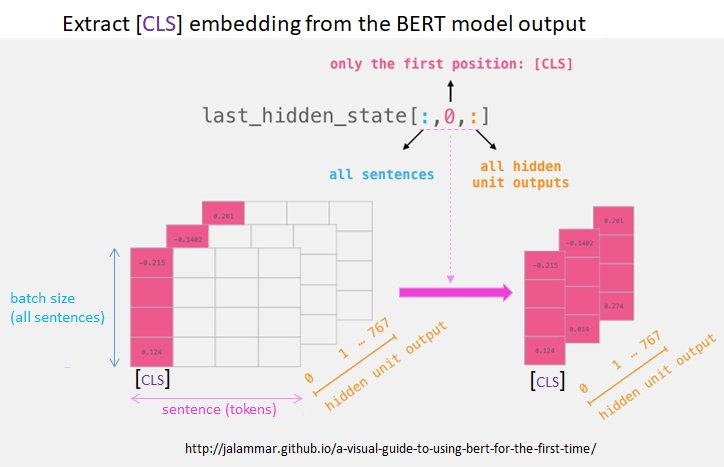

Using custom loss functions sometimes could be tricky. The function that we want to use is the `f1 score`. It is known for being more accurate than the `accuracy` function. 

Thanks to [@rejpalcz](https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric?scriptVersionId=6633544&cellId=17)

In [ ]:
def f1(y_true, y_pred):
    from tensorflow.keras.backend import epsilon
    y_pred = tf.round(y_pred)
    # Calculate the true positive
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32), axis=0)
    # Calculate the true negative
    tn = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), tf.float32), axis=0)
    # Calculate the false positive
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32), axis=0)
    # Calculate the false negative
    fn = tf.reduce_sum(tf.cast(y_true * (1- y_pred), tf.float32), axis=0)
    
    # Calculate Precision
    precision = tp / (tp + fp + epsilon())
    
    # Calculate Recall
    recall = tp / (tp + fn + epsilon())
    
    # Calculate f1
    f1 = (2 * precision * recall) / (precision + recall + epsilon())
    # check null value and map with zeros
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.reduce_mean(f1)

In [ ]:
def build_model(n_grams_dense_units: List[int],
                mode: Text='TRAIN',
                dropout: float=None,
                l1_reg: float=None,
                lr: float=None,
                weight_decay: float=None) -> tf.keras.models.Model:
    inputs = {
        'input_ids': tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH, ),
                                           dtype=tf.int32,
                                           name='distilbert_input_ids'),
        'attention_mask': tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH, ),
                                           dtype=tf.int32,
                                           name='distilbert_attention_mask'),
        'bi_grams': tf.keras.layers.Input(shape=(MAX_BI_GRAMS_LEN, ),
                                         dtype=tf.float32,
                                         name='bi_grams'),
        'tri_grams': tf.keras.layers.Input(shape=(MAX_TRI_GRAMS_LEN, ),
                                           dtype=tf.float32,
                                           name='tri_grams')}
    
    # (1) distilbert base layer
    distilbert = TFDistilBertModel.from_pretrained(MODEL_NAME, num_labels=2)
    
    # Freeze the distilbert model weights not to train them.
    if FREEZE_DISTILBERT:
        for layer in distilbert.layers:
            layer.trainable = False
    # [CLS] embedding is `last_hidden_state[:, 0, :]
    distilbert_output = distilbert([inputs['input_ids'],
                                    inputs['attention_mask']]).last_hidden_state[:, 0, :]
    
    # (2) bi-gram
    bi_layer = Dropout(dropout, name='bi_gram_dropout')(inputs['bi_grams'])
    for index, unit in enumerate(n_grams_dense_units):
        bi_layer = Dense(units=unit,
                      activation='relu',
                      kernel_initializer='glorot_uniform',
                      name=f'bi_gram_dense_{index+1}')(bi_layer)
        bi_layer = Dropout(dropout,
                          name=f'bi_gram_dropout_{index+1}'
                          )(bi_layer)
    
    # (3) tri-gram
    tri_layer = Dropout(dropout, name='tri_gram_dropout')(inputs['tri_grams'])
    for index, unit in enumerate(n_grams_dense_units):
        tri_layer = Dense(units=unit,
                      activation='relu',
                      kernel_initializer='glorot_uniform',
                      name=f'tri_gram_dense_{index+1}')(tri_layer)
        tri_layer = Dropout(dropout,
                            name=f'tri_gram_dropout_{index+1}')(tri_layer)
        
    # concatenate all the layers
    concat = concatenate([distilbert_output, bi_layer, tri_layer])
    
    # Assign custom head
    if USE_CUSTOM_HEAD:
        # Comb 01
        dense_layer_1 = Dense(units=NUM_BASE_MODEL_OUTPUT,
                              kernel_initializer='glorot_uniform',
                              name='hidden_layer_no_regulizer_1')(concat)
        dropout_1 = Dropout(rate=0.15)(dense_layer_1)
        dense_layer_2 = Dense(units=NUM_BASE_MODEL_OUTPUT,
                              kernel_initializer='glorot_uniform',
                              name='hidden_layer_no_regulizer_2')(dropout_1)
        
        batch_norm_1 = BatchNormalization(name='batch_normalization01')(dense_layer_2)
        activation_1 = Activation('leaky_relu', name='leaky_relu_01')(batch_norm_1)
                
        # Comb 02
        dense_layer_3 = Dense(units=NUM_BASE_MODEL_OUTPUT,
                              kernel_initializer='glorot_uniform',
                              name='hidden_layer_no_regulizer_3')(activation_1)
        batch_norm_2 = BatchNormalization(name='batch_normalization02')(dense_layer_3)
        
        # Combining faster and better converages of Linear Unit functions
        # Plus applying the regularization applied by Dropout
        # to read more: https://medium.com/@shoray.goel/gelu-gaussian-error-linear-unit-4ec59fb2e47c
        activation_1 = Activation(tf.keras.activations.gelu,
                                  name='leaky_relu_02')(batch_norm_2)
        
        # activation function is sigmoid since we're having a binary classifier
        # also, we need to control the radio as we discussed previously
        output = Dense(units=1,
                       kernel_initializer='glorot_uniform',
                       kernel_regularizer=tf.keras.regularizers.L1(l1=l1_reg),
                       activation='sigmoid',
                       name='tweet_status')(activation_1)
        
        model = Model(inputs=inputs, outputs=output, name='distilbert-n-gram-fine-tuned-sst')
        
        if mode != 'INF':
            model.compile(
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                # you can find AdamW for Adam weight decay in 
                ## https://www.tensorflow.org/addons
                optimizer=tfa.optimizers.AdamW(learning_rate=lr,
                                               weight_decay=weight_decay),
                metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         f1])
        
        return model

**Testing the model**

<center><h4 style='color:CornflowerBlue; text-align:center;'><b>Model Summary</b></4></center>

In [ ]:
model = build_model(n_grams_dense_units = [256, 128, 64],
                    dropout= 0.2,
                    l1_reg = 0.01,
                    lr = 5e-5,
                    weight_decay=1e-4)
model.summary()

<center><h4 style='color:CornflowerBlue; text-align:center;'><b>Model Graph</b></4></center>

In [ ]:
tf.keras.utils.plot_model(model)

# <font size='3' color='SteelBlue'><b>(B) Train & Validate Model</b></font>

<center><img src='https://lever-client-logos.s3.amazonaws.com/bb006941-a5fe-4d4c-b13d-931f9b9c303f-1569362661885.png'></center>
    
<center><a href='https://wandb.ai'>Uploaded from Weights & Biases</a></center>

Weights & Biases is one of the great tools for Building better models faster with experiment tracking, dataset versioning, and model management. It will help us track our model and see how it is doing in training.

In [ ]:
# Save train data to W&B Artifacts
run = wandb.init(project="TwitterNLP",
                 name='training_data',
                 anonymous=anony,
                 config=CONFIG)

artifact = wandb.Artifact(name='training_data',
                          type='dataset')

# I have added the file
artifact.add_file('./twitter_preproccessed_datasets/training_datasets/train.csv')

wandb.log_artifact(artifact)
wandb.finish()

In [ ]:
# Initialize the variables
TRAIN_EXAMPLES = train.shape[0]
DEVELOPMENT_EXAMPLES = dev.shape[0]
TEST_EXAMPLES = test.shape[0]
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
DROP_RATE = 0.2
BATCH_SIZE = 128
NUM_EPOCHS = 15
L1_REGU = 0.01

**Create Directories**

In [ ]:
MODELING = 'model_and_metadata'
MODEL_DIR = 'model'
CHECKPOINT = 'checkpoints'

if not os.path.isdir(MODELING):
    os.mkdir(MODELING)
if not os.path.isdir(os.path.join(MODELING, MODEL_DIR)):
    os.mkdir(os.path.join(MODELING, MODEL_DIR))
if not os.path.isdir(os.path.join(MODELING, CHECKPOINT)):
    os.mkdir(os.path.join(MODELING, CHECKPOINT))

In [ ]:
def train_and_evaluate(train_path: Text, 
                       dev_path: Text,
                       with_label: Optional[bool],
                       batch_size: int,
                       epochs: int,
                       dropout: float,
                       n_grams_dense_units: List[int],
                       l1_reg: float,
                       lr: float,
                       weight_decay: float,
                       model_dir: Text,
                       checkpoint_path: Text,
                       start_from_latest_checkpoint: Optional[bool]=False
                      ) -> None:
    """
    | Train & Evaluate function is responsible for training and evaluating the model
    | in a distributed manner. After finishing training, it will save the model for serving.
    Args:
        train_path [Text]: Path where we're going to retrieve our training data.
        dev_path [Text]: Path where we're going to retrieve our development data.
        with_label [Optional[bool]]: whether the dataset has label or not. (Default: True) 
        batch_size [int]: numbers of example per batch.
        epochs [int]: numbers of times proving the data for training.
        dropout [float]: A regulizer for the model.
        l1_reg [float]: regularizer of the label.
        lr[float]: it represents the learning rate.
        weight_decay [float]: it represents the decay rate for the model optimizer.
        n_grams_dense_units [int]: numbers of units of our dense layers.
        model_dir [Text]: location for saving our model.
        checkpoint_path [Text]: location for saving our model's checkpoints.
        start_from_latest_checkpoint [Optional[bool]]: it gives you the option that start
                                                       training from the last point you
                                                       finished last time. (Default: False)
    """
    import logging
    import datetime
    
    def plot_model_results(variable_name: Text) -> None:
        plt.plot(history.history[variable_name])
        plt.plot(history.history[f'val_{variable_name}'])
        plt.title(f'model {variable_name}')
        plt.ylabel(variable_name)
        plt.xlabel('epoch')
        plt.legend(['Train', 'Development'], loc='upper left')
        plt.show()
    # Apply strategy for Distributed input
    ## using Hierarchical copy all-reduce implementation of CrossDeviceOps.
    ### https://www.tensorflow.org/api_docs/python/tf/distribute/HierarchicalCopyAllReduce
    mirrored_strategy = tf.distribute.MirroredStrategy(
                        cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

    # Load the train data & development Data
    train_features, train_label = load_data_fn(dataset_path=train_path, with_label=with_label)
    dev_features, dev_label = load_data_fn(dataset_path=dev_path, with_label=with_label)

    # Build Distributed Input Dataset
    ## create training dataset
    train_ds = input_fn(text_features=train_features,
                        label=train_label,
                        mode="TRAIN")
    ## create development dataset
    dev_ds = input_fn(text_features=dev_features,
                      label=dev_label,
                      mode="DEV")
    ## Distributed training dataset
    train_ds = mirrored_strategy.distribute_datasets_from_function(lambda input_context:
                                                                   distributed_input_fn(train_ds,
                                                                                        batch_size=batch_size,
                                                                                        epochs=epochs,
                                                                                        mode="TRAIN",
                                                                                        input_context=input_context))
    ## Distributed development dataset
    dev_ds = mirrored_strategy.distribute_datasets_from_function(lambda input_context:
                                                                 distributed_input_fn(dev_ds,
                                                                                      batch_size=batch_size,
                                                                                      epochs=epochs,
                                                                                      mode="DEV",
                                                                                      input_context=input_context))
    GLOBAL_BATCH_SIZE = batch_size * mirrored_strategy.num_replicas_in_sync
    # Build Distributed Training model
    with mirrored_strategy.scope():
        try:
            model = build_model(dropout=dropout,
                                n_grams_dense_units=n_grams_dense_units,
                                l1_reg=l1_reg,
                                lr=lr,
                                weight_decay=weight_decay)
        except ValueError:
             if start_from_latest_checkpoint:
                latest = tf.train.latest_checkpoint('checkpoints')
                model.load_weights(latest)
        except ValueError:
            logging.error("You've changed the layers' structure of the model.\nThis model can't execute the previous checkpoint on this recent model's skeleton.")

    
    # Initializing the callbacks
    wandb.init(project="TwitterNLP")
    wandb.config = {
      "learning_rate": lr,
      "epochs": epochs,
      "batch_size": GLOBAL_BATCH_SIZE
    }
    checkpoint_file_prefix = checkpoint_file_prefix = "distilbert-n-gram-fine-tuned-sst-checkpoints-epochs-{epoch:02d}-val_f1-{val_f1:0.4f}-time-" +\
                             datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    checkpoints = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_path,
                              checkpoint_file_prefix),
                              monitor='val_accuracy',
                              save_best_only=True,
                              save_weights_only=True,
                              mode= 'max',
                              verbose=1)
    ES = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                          patience=2,
                                          mode='max',
                                          verbose=1)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                     factor=1e-3,
                                                     mode='max',
                                                     patience=0,
                                                     verbose=1)
    # Model Training
    clear_output(wait=True)
    tf.print(' Start Training '.center(100, '='))
    history = model.fit(train_ds,
                        validation_data=dev_ds,
                        validation_steps = DEVELOPMENT_EXAMPLES // GLOBAL_BATCH_SIZE,
                        steps_per_epoch=TRAIN_EXAMPLES // GLOBAL_BATCH_SIZE,
                        epochs=epochs,
                        callbacks=[checkpoints, WandbCallback(), ES, reduce_lr])
    
    # Model Evaluating
    tf.print(' Model Training Finished'.center(100, '='))
    tf.print()    
    tf.print(' Plotting Performance '.center(100, '='))
    tf.print(' Accuracy '.center(50, '*'))
    plot_model_results('accuracy')
    tf.print(' F1-score '.center(50, '*'))
    plot_model_results('f1')
    tf.print(' Loss '.center(50, '*'))
    plot_model_results('loss')

    
    tf.print()
    loss, train_bin_accuracy, train_f1 = model.evaluate(train_ds,
                                              steps=TRAIN_EXAMPLES // GLOBAL_BATCH_SIZE,
                                              verbose=0)
    val_loss, dev_bin_accuracy, dev_f1 = model.evaluate(dev_ds,
                                              steps=DEVELOPMENT_EXAMPLES // GLOBAL_BATCH_SIZE,
                                              verbose=0) 

    tf.print(' Training & Evaluation Performance '.center(100, '='))
    tf.print(' Training Performance '.center(50, '*'))
    tf.print(f'Loss: {loss}\nBinary Accuracy: {train_bin_accuracy}\nF1-score: {train_f1}')
    tf.print()
    tf.print(' Evaluation Performance '.center(50, '*'))
    tf.print(f'Loss: {val_loss}\nBinary Accuracy: {dev_bin_accuracy}\nF1-score: {dev_f1}')
    
    # Saveing model weights
    model_dir = os.path.join(model_dir, 
                             f"distilbert-n-gram-fine-tuned-sst-{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
    
    tf.print(f'\nModel Name: {model_dir}')
    model.save_weights(model_dir)

<center><h4 style='color:Aqua; text-align:center;'><b>Finally Training Started!!!</b></4></center>

In [ ]:
train_and_evaluate('./twitter_preproccessed_datasets/training_datasets/train.csv', 
                   './twitter_preproccessed_datasets/training_datasets/dev.csv',
                   True,
                   32,
                   50,
                   DROP_RATE,
                   [256, 128, 64],
                   L1_REGU,
                   LEARNING_RATE,
                   WEIGHT_DECAY,
                   os.path.join(MODELING, MODEL_DIR),
                   os.path.join(MODELING, CHECKPOINT))

# <font size='5' color='DarkSlateBlue'>6. Inference</font>

# <font size='3' color='SteelBlue'><b>(A) Load The Model's Weights</b></font>

In [ ]:
BEST_CHECKPOINT = os.path.join('model_and_metadata/checkpoints',sorted(os.listdir('model_and_metadata/checkpoints'))[-1][:93])
BEST_CHECKPOINT

In [ ]:
model = build_model(mode='INF',
                    dropout=DROP_RATE,
                    n_grams_dense_units=[256, 128, 64],
                    l1_reg=L1_REGU)
model.load_weights(BEST_CHECKPOINT)

# <font size='3' color='SteelBlue'><b>(B) Load Test Dataset</b></font>

In [ ]:
# Load the test dataset
test_features = load_data_fn(dataset_path='./twitter_preproccessed_datasets/training_datasets/test.csv',
                             with_label=False)
# Build Distributed Input Dataset
## create Testing dataset
test_ds = input_fn(text_features=test_features,
                   label=None,
                   mode="TEST")
mirrored_strategy = tf.distribute.MirroredStrategy(
                        cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
test_ds = mirrored_strategy.distribute_datasets_from_function(lambda input_context:
                                                                   distributed_input_fn(test_ds,
                                                                                        batch_size=1,
                                                                                        epochs=1,
                                                                                        mode="TEST",
                                                                                        input_context=input_context))

# <font size='3' color='SteelBlue'><b>(C) Test The Model</b></font>

In [ ]:
predictions_probability = model.predict(test_ds, steps=TEST_EXAMPLES)

We talked about the biased in our dataset – our dataset biased (Unsampled) towards `Non-disasters` tweets more than `Disasters` tweets; therefore, we're going to test both making our threshold on `50%` and check the accuracy of the predictions then we're going to set the threshold on `57%` and also check the accuracy of the model

In [ ]:
def pred_threshold_with_logits(predictions: np.array, threshold: int) -> np.array:
    # Reduce the dimension of the predictions
    predictions = predictions.squeeze(1)
    return np.asarray([1 if pred > threshold
                       else 0
                       for pred in predictions])

Number of `Non-Disaster` and `Disaster` in Test data

In [ ]:
pred_threshold_with_logits(predictions_probability, 0.50)

In [ ]:
test.target.value_counts()

Number of `Non-Disaster` and `Disaster` in predictions with **50%** Threshold

In [ ]:
np.bincount(pred_threshold_with_logits(predictions_probability, 0.50))

Number of `Non-Disaster` and `Disaster` in predictions with **57%** Threshold

In [ ]:
np.bincount(pred_threshold_with_logits(predictions_probability, 0.57))

# <font size='3' color='SteelBlue'><b>(D) Evaluate the predictions</b></font>

In [ ]:
y_true = test['target']
predictions = pred_threshold_with_logits(predictions_probability, 0.50)

In [ ]:
cm = confusion_matrix(y_true, predictions,
                      labels=[0,1]
                      )
confusion_plot = ConfusionMatrixDisplay(confusion_matrix=cm,
                                        display_labels=['Non-Disaster','Disaster'])

fig, ax = plt.subplots(1,1,figsize=(12, 8))
ax.grid(False)
confusion_plot.plot(cmap='Blues', ax=ax)
plt.gca().invert_yaxis()
ax.set_title('Confusion Matrix Between True Label & Predicted Label')
plt.show()

In [ ]:
print(classification_report(y_true, predictions))

In [ ]:
print('F1-score: ', f1(y_true, predictions).numpy())

# <font size='3' color='SteelBlue'><b>(E) Inference Submission</b></font>

In [ ]:
INF_EXAMPLES = len(test_data)

In [ ]:
submission_data = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [ ]:
# Load the test dataset
sub_features = load_data_fn(dataset_path='./twitter_preproccessed_datasets/twitter_deep_preprocessed_test.csv',
                             with_label=False)
# Build Distributed Input Dataset
## create Testing dataset
sub_ds = input_fn(text_features=sub_features,
                   label=None,
                   mode="TEST")
mirrored_strategy = tf.distribute.MirroredStrategy(
                        cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
sub_ds = mirrored_strategy.distribute_datasets_from_function(lambda input_context:
                                                                   distributed_input_fn(sub_ds,
                                                                                        batch_size=1,
                                                                                        epochs=1,
                                                                                        mode="TEST",
                                                                                        input_context=input_context))

In [ ]:
sub_predictions_probability = model.predict(sub_ds, steps=INF_EXAMPLES)

In [ ]:
np.bincount(pred_threshold_with_logits(sub_predictions_probability, 0.5))

In [ ]:
submission_data.target = pred_threshold_with_logits(sub_predictions_probability, 0.5)

In [ ]:
submission_data

# <font size='3' color='SteelBlue'><b>(D) Save Inference Submission</b></font>

In [ ]:
SUBMISSION = 'submissions' 
SUBMISSION = os.path.join('.', SUBMISSION)

In [ ]:
if not os.path.isdir(SUBMISSION): os.mkdir(SUBMISSION)
to_csv(submission_data, SUBMISSION, 'submission.csv')

***

# ※<font size='5' color='DarkViolet'>References</font>

- [Best NLP Disaster Tweets Classifier!](https://www.kaggle.com/georgesaavedra/best-nlp-disaster-tweets-classifier).

- [Getting started with Text Preprocessing](https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing) from the man himself [@sudalairajkumar](https://www.kaggle.com/sudalairajkumar)


- Table Coloring [@egeakyol](https://www.kaggle.com/egeakyo).

- [Correcting Words using Python and NLTK](https://rustyonrampage.github.io/text-mining/2017/11/28/spelling-correction-with-python-and-nltk.html)

- [Step 3: Prepare Your Data](https://developers.google.com/machine-learning/guides/text-classification/step-3#figure-6)

- [Base Model - TFDistilBertModel](https://stackoverflow.com/questions/69025750/how-to-fine-tune-huggingface-bert-model-for-text-classification#:~:text=base%20model%20-%20tfdistilbertmodel)

- [Optimal loss function - macro F1 score](https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric?scriptVersionId=6633544&cellId=17)

- [W & B Artifacts](https://www.kaggle.com/usharengaraju/tensorflow-tabtransformer?scriptVersionId=86768241&cellId=22)

- [tf.distribute.Strategy.distribute_datasets_from_function](https://www.tensorflow.org/tutorials/distribute/input#tfdistributestrategydistribute_datasets_from_function)

- Thanks to Mrs. [Tensor Girl](https://www.kaggle.com/usharengaraju) – [TensorFlow Probability ProbabilisticBNN](https://www.kaggle.com/usharengaraju/tensorflow-probability-probabilisticbnn?scriptVersionId=86257485&cellId=27)

- [Visualize Model Training History in Keras](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/#:~:text=visualize%20model%20training%20history%20in%20keras)

<center>
________________________________
</center>

<p style='text-align:center;'>Thanks for reaching this level of expermenting
the idea of</p>
<center><p style='text-align:center;'><b>Disaster Tweets – Deep NLP Analysis & [<img src='https://i.imgur.com/DFetacC.png' width='15px' height='25px'/>] Distributed Training DistilBert-N-grams-sst-en</b></p></center>
<p style='text-align:center;'>AI Engineer: <a href='https://www.linkedin.com/in/drxavier997/'>Ahmed</a></p>
<p style='text-align:center;'>Created at: 2022-01-16<br>